The goal of this task is to implement a Hidden Markov Model and inferring the most likely sequence of states using the Viterbi algorithm.
Additionally, the inference tasks prediction and smoothing have to be implemented.

We all know that COVID-19 has been spreading for more than two years by now. In order to fight the pandemic,
many restrictions have been implemented and are changing constantly. As a result, conducting our exam on-site is
in danger. We want to find out if we again will have to resort to an online exam.

To do so, we want to use an HMM modeling the spread of the virus. This HMM will have 7 hidden states, called
severity levels. Severity is derived by combining a region's monthly cases and deaths. Severity 1 is the lowest,
7 the highest.

For the observations, we collected the number of new cases and deaths for the regions of Munich and Landkreis Munich (where Garching
is located).

A purely fictional Bavarian king, named Markus IV.,
rolled his seven-sided die and has it proclaimed that our exam can only take place on-site if the severity
level in February 2022 is below 6 in Munich and Garching. Will he allow us to conduct the exam in person?

Your task is to complete the missing code. Make sure that all the functions follow the provided interfaces of the
functions, i.e., the output of the function exactly matches the description in the docstring.
You only have to modify code that is in a block like this:

```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```

### Learning Outcomes:

* Implementation of the Viterbi algorithm
* Implementation of smoothing and prediction

### Import

For testing and grading, we want to state that you are not allowed to import
any other libraries and should not change the structure of the provided functions
(i.e, the arguments and the name of the functions).

In [47]:
import numpy as np

import visualization.visualize_data as vis
import helpers.utils as ut

### Corona data visualization (Nothing to implement here)

Before we start to model the corona situation, we would like to visualize the data first to have a basic understanding of it. Feel free to change some parameters to achieve different visualization settings. Have fun!

In [48]:
# load the corona data
corona_df, munich_map_df = vis.load_data()

In [49]:
# check what munich_map_df looks like
munich_map_df

,USE,RS,RS_ALT,GEN,SHAPE_LENG,SHAPE_AREA,geometry
0,4,01001,010010000000,Flensburg,32467.034276,5.324899e+07,"POLYGON ((9.48982 54.82296, 9.50467 54.81004, ..."
1,4,01002,010020000000,Kiel,73027.302434,1.218654e+08,"POLYGON ((10.19057 54.38909, 10.18370 54.38910..."
2,4,01003,010030000000,Lübeck,104861.094220,2.211386e+08,"POLYGON ((10.89297 53.95695, 10.90337 53.95705..."
3,4,01004,010040000000,Neumünster,39858.818376,8.092363e+07,"POLYGON ((10.03454 54.12915, 10.02277 54.10938..."
4,4,01051,010510000000,Dithmarschen,202206.675707,1.450311e+09,"MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3..."
...,...,...,...,...,...,...,...
397,4,16073,160730000000,Saalfeld-Rudolstadt,209670.746788,1.023057e+09,"POLYGON ((11.42397 50.80862, 11.42072 50.80306..."
398,4,16074,160740000000,Saale-Holzland-Kreis,172686.880125,8.176883e+08,"POLYGON ((12.01807 50.96757, 12.02085 50.94806..."
399,4,16075,160750000000,Saale-Orla-Kreis,185679.957051,1.144877e+09,"POLYGON ((11.94482 50.59236, 11.92423 50.58608..."
400,4,16076,160760000000,Greiz,222979.605428,8.509542e+08,"POLYGON ((12.22219 50.94284, 12.23787 50.92905..."


In [50]:
# extract Munich and LK Munich
munich_map_df = vis.extract_data(munich_map_df)

In [51]:
# check what corona_df looks like
corona_df

,GEN,ObservationDate,Confirmed,Deaths
0,Munich,2020-04-01T17:00:00+0000,70.2,118.25
1,Munich,2020-04-02T17:00:00+0000,69.4,115.36
2,Munich,2020-04-03T17:00:00+0000,65.3,117.45
3,Munich,2020-04-04T17:00:00+0000,64.4,115.58
4,Munich,2020-04-05T17:00:00+0000,68.2,118.12
...,...,...,...,...
1275,LK Munich,2021-12-27T17:00:00+0000,198.1,0.00
1276,LK Munich,2021-12-28T17:00:00+0000,195.7,0.00
1277,LK Munich,2021-12-29T17:00:00+0000,193.7,0.00
1278,LK Munich,2021-12-30T17:00:00+0000,192.1,0.00


In [52]:
# Both dataframes have the column "GEN", we merge them using this column
joined_df = vis.join_dataframes(corona_df, munich_map_df)

# Check the final dataframe before we do the visualization
joined_df

,GEN,Confirmed,Deaths,geometry,date_sec
0,Munich,70.2,118.25,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585760400
1,Munich,69.4,115.36,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585846800
2,Munich,65.3,117.45,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1585933200
3,Munich,64.4,115.58,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1586019600
4,Munich,68.2,118.12,"POLYGON ((11.55265 48.22802, 11.55420 48.22292...",1586106000
...,...,...,...,...,...
1275,LK Munich,198.1,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640624400
1276,LK Munich,195.7,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640710800
1277,LK Munich,193.7,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640797200
1278,LK Munich,192.1,0.00,"POLYGON ((11.58252 48.29474, 11.59326 48.28478...",1640883600


In [53]:
# visualize the daily confirmed cases
colour_map_cases, slider_map_cases = vis.visualize_corona_data(joined_df, "Confirmed")
colour_map_deaths, slider_map_deaths = vis.visualize_corona_data(joined_df, "Deaths")


In [54]:
# final visualization, drag the bar to see the statistics on different days
#slider_map_cases
# uncomment to see the deaths
slider_map_deaths


### Build the HMM model

In our HMM model, there are two observations: Confirmed cases per 100,000 people and death cases per 5,000,000 people.
Unlike the umbrella case in the textbook, our data is continuous, which means we need a continuous HMM model.
But don't worry! The transition from a discrete HMM model to a continuous one is easy. In this task, you are only
supposed to implement a discrete model.

Let's define a class named HMM that is able to execute filtering, smoothing, prediction and the Viterbi algorithm
based on discrete observation data. You will implement the aforementioned functions step by step
within the **HMM** class. Vectorized operations given in the textbook will be very useful for during implementation.

**Note: During implementation, we refer the state with their associated indices.**
For example, as defined in the textbook, the ij-th entry of transition matrix denotes the transformation probability
from state j to state i.

In [55]:
class HMM():
    def __init__(self,
                 observation_mu,
                 observation_sigma,
                 transition_matrix,
                 initial_probability):
        assert len(transition_matrix) == len(observation_mu) == len(observation_sigma)
        self.trans_mat = transition_matrix
        self.obs_mat = ut.get_obs_mat(observation_mu, observation_sigma)
        self.init_prob = initial_probability
        self.N_state = len(self.trans_mat)

    def compute_observation_matrix(self, observation):
        """ Compute the observation matrix for vectorized operation.

        Args:
            observation: observation in some timestamp

        Return:
            O_matrix: observation matrix

        """
        prob_density = [self.obs_mat[i].pdf(observation) for i in range(self.N_state)]
        O_matrix = np.diag(prob_density)
        return O_matrix


    def forward_onestep(self, f, observation):
        """ Compute one forward step for filtering.
            N stands for number of hidden states.
            Hint: Use the O_matrix we provided for one step forward opration.

        Args:
            f: numpy array with shape [N, ], vector of f_{1:t} depicting probability of state given previous observation sequence
            observation: observed state in timestamp t+1


        Return:
            f_onestep: numpy array with shape [N, ], updated vector of f_{1:t+1}

        """
        # Acquire the row vector and transform it to diagonal matrix
        O_matrix = self.compute_observation_matrix(observation)
        f_onestep = None
        #######################################
        # YOUR CODE HERE
        # f_{1:t+1} = a*O_{t+1}Tf_{1:t}
        #print("O_matrix: ",O_matrix)
        f_onestep = self.normalize(O_matrix@(self.trans_mat)@f)
        #######################################
        return f_onestep


    def backward_onestep(self, b, observation):
        """ Compute one backward step for smoothing
            N stands for number of hidden states.
            Hint: Use the O_matrix we provided for one step backward.

        Args:
            b: numpy array with shape [N, ], vector of b_{k+2:T} depicting probability of observation sequence given state
            observation: observed state in timestamp k+1

        Return:
            b_onestep: numpy array with shape [N, ], updated vector of b_{k+1:T}

        """
        # Acquire the row vector and transform it to diagonal matrix
        O_matrix = self.compute_observation_matrix(observation)
        b_onestep = None
        #######################################
        # YOUR CODE HERE
        b_onestep = (self.trans_mat.T)@O_matrix@b
        #######################################
        return b_onestep


    def forward_backward(self, observation_sequence):
        """ forward-backward algorithm for smoothing
            In this function, you will finalize the forward-backward algorithm based on your previous implementations
            of function “forward_onestep” and "backward_onestep".

            Remember to normalize the result smoothed probability to ensure the probability sum to be 1!
            Note: We provide normalization function as a reference, you can also implement your own :)

            T stands for sequence length and N stands for number of hidden states.

        Args:
            observation_sequence: observed sequence in a given period with length T


        Return:
            smoothed_prob: numpy array with shape [T, N], state probability in this period after smoothing.

        """
        forward_prob = {}
        smoothed_prob = {}
        backward_prob = {}
        #######################################
        # YOUR CODE HERE
        T = observation_sequence.shape[0]
        f_t = self.init_prob
        for i in range(T):
            f_t = self.forward_onestep(f_t,observation_sequence[i])
            forward_prob[i] = f_t
        b_T = np.ones(self.N_state)
        for j in range(T-1,-1,-1):
            sv = self.normalize(forward_prob[j]*b_T)
            smoothed_prob[j] = sv
            b_T = self.backward_onestep(b_T,observation_sequence[j])

        #######################################
        return ut.dict_to_array(smoothed_prob)


    def predict(self, observation_sequence, k):
        """ Predict state probability for future timestamp, remember to filter the given observation sequence at first.

            Remember to normalize the result forward probability to ensure the probability sum to be 1!
            Note: We provide normalization function as a reference.

            N stands for number of hidden states.

        Args:
            observation_sequence: observed sequence in a given period with length T
            k: the number of steps of timestamp T

        Return:
            p: numpy array with shape [N, ], vector of state probability after k steps of timestamp T in the future

        """
        prediction = {}
        #######################################
        # YOUR CODE HERE
        # 1.filtering to get p(x_t|e_{1:t})
        T = observation_sequence.shape[0]
        p_t = self.init_prob
        for t in range(T):
            p_t = self.forward_onestep(p_t,observation_sequence[t])
        # 2.calculate p(x_{t+k}|e_{1:t})
        prediction = np.linalg.matrix_power(self.trans_mat,k)@p_t
        # 3.state probability p(x_{t+k})?

        #######################################
        return prediction


    def get_predicted_state(self, prediction):
        """ Find the index of the most likely state in the prediction.

        Args:
            prediction: numpy array with shape [N, ], vector of state probabilities

        Return:
            state: integer that is the index of the most likely state in prediction
        """
        state = {}
        ######################################################
        # YOUR CODE HERE
        state = np.argmax(prediction)+1 # from 1 to 7
        ########################################################
        return state


    def viterbi(self, observation_sequence):
        """ Compute the most likely state trajectory given an observation sequence.
            T stands for sequence length.

        Args:
            observation_sequence: observed sequence in a given period with length T

        Return:
            trajectory: numpy array with shape [T, ], trajectory of the most likely state in the given period.
            Note that the output trajectory is in the form of the corresponding indices of the states. For example,
            the output with numpy array [1, 7, 5] denotes given a sequence with length T=3, the most likely state
            transforms from state 1 to state 7 and finally to state 5.
        """
        max_prob = {}
        most_likely_state = {}
        trajectory = {}
        #######################################
        # YOUR CODE HERE
        T_size = observation_sequence.shape[0]
        #print("T_size = ", T_size)
        # 1. initialization
        P_xe = self.forward_onestep(self.init_prob,observation_sequence[0])# P(x_1|e_{1:1})
        # most_likely_state[0] = np.argmax(P_xe)
        # 2. forward maxmum
        # print("O_matrix: ",O_matrix)
        for i in range(1,T_size,1):
            #print("P_xe: ",P_xe)
            O_matrix = self.compute_observation_matrix(observation_sequence[i])
            P_xe0 = self.trans_mat*P_xe
            most_likely_state[i] = np.argmax(P_xe0,axis=1)   
            P_xe = O_matrix@np.max(P_xe0,axis=1)
        #print("most: ",most_likely_state)
        # 3. backtrack
        trajectory[T_size] = np.argmax(P_xe)
        for t in range(T_size-1,0,-1):
            trajectory[t] = most_likely_state[t][trajectory[t+1]]
        # 4. from 1 to 7
        for key in trajectory.keys():
            trajectory[key] += 1
        #######################################
        return ut.dict_to_array(trajectory)

    @staticmethod
    def normalize(logit, axis=0):
        prob = logit / np.sum(logit, axis=axis)
        return prob


### Apply HMM for COVID-19 Severity Estimation

In this section, your final task is to use the use HMM model for COVID-19 severity estimation as a guide for examination decision-makers.

You may refer to this [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9543670) to better understand how we can leverage HMM to model the spread progress of COVID-19 given some observation data such as daily and cumulative infections and daily deaths.

In this task, we define the following components of HMM as follows:

```
Hidden State: Severity of the COVID, there are 7 discrete levels in total and the transition diagram is shown in below.
Observation: A 7 * 2 matrix (mus) and a 7 * 2 * 2 matrix (sigmas)
Transformation Model: A 7 * 7 matrix that depicts the internal relationship between each state.
Sensor Model: A 2-dimensional gaussian distribution based on given state.
```

It can be a little tricky since in this scenario the sensor model is modeled as a continuous probability density distribution instead of a discrete matrix as discussed during lectures. While don't be panic since we have  provided you a helper function to extract the diagonal observation matrix (O_matrix), and then the algorithm for filtering, smoothing and viterbi will be just the same as the discrete case we dealt with during class.

We will provide pre-estimated HMM parameters for you such as transformation matrix and preprocessed data, let's now take a look on how we use HMM to model COVID-19.

### Transition Matrix

We define the transitional matrix as the following figure shows:
![title](img/transitional_matrix.png)

In [56]:
#######################################
# T is a 7 * 7 matrix, T(ij) means the probability from state j to state i

T = np.array([[0.989, 0.002, 0.008, 0.000, 0.000, 0.000, 0.000],
              [0.004, 0.984, 0.005, 0.004, 0.004, 0.000, 0.000],
              [0.007, 0.002, 0.977, 0.009, 0.000, 0.000, 0.000],
              [0.000, 0.007, 0.010, 0.973, 0.006, 0.000, 0.009],
              [0.000, 0.005, 0.000, 0.009, 0.977, 0.014, 0.004],
              [0.000, 0.000, 0.000, 0.000, 0.010, 0.981, 0.003],
              [0.000, 0.000, 0.000, 0.005, 0.003, 0.005, 0.984]])


### Observation Matrix

We define the observational matrix as the following figure shows:
<img src='./img/observational_matrix.PNG'  width='35%'  height='35%'>

In [57]:
#######################################
# mus is a 7 * 2 matrix, which indicates the input mean of gaussian variable
# sigmas is a 7 * 2 * 2 matrix, which indicates the input covariance of gaussian variable. Each state has a 2 * 2 covariance matrix

mus = np.array([[0.000, 2.842],
                [7.105, 43.526],
                [8.365, 5.425],
                [54.292, 35.294],
                [123.655, 150.556],
                [255.332, 390.887],
                [331.681, 162.652]])


sigmas = np.zeros((7, 2, 2))
sigmas[0] = np.array([[0.049, 0],
                      [0, 14.896]])
sigmas[1] = np.array([[41.209, 16.856],
                      [16.856, 664.93]])
sigmas[2] = np.array([[39.984, 11.417],
                      [11.417, 12.691]])
sigmas[3] = np.array([[658.07, 310.464],
                      [310.464, 430.269]])
sigmas[4] = np.array([[3584.35, 1716.96],
                      [1716.96, 2281.93]])
sigmas[5] = np.array([[28086.8, 17875.2],
                      [17875.2, 19007.1]])
sigmas[6] = np.array([[26891.2, 15268.4],
                      [15268.4, 14259]])


### Initialized State Distribution

In [58]:
# init_prob is a 7-dimensional vector
init_prob = np.array([0.414, 0, 0.401, 0.137, 0, 0, 0.047])

### Observation Sequence

Since we take into account 21 months in total, the sequence is a 21 * 2 matrix which contains both confirmed cases and death cases.

**The sequence can be found in sequence.csv**

In [59]:
# observation sequence is a 21 * 2 matrix containing both confirmed cases and death cases, here, we define 2 sequences, one for Munich,
# one for LK_Munich

obs_seq_Munich = np.array([[183, 358],
                           [45, 54],
                           [24, 1],
                           [34, 0],
                           [110, 0],
                           [191, 14],
                           [415, 124],
                           [914, 708],
                           [969, 1282],
                           [507, 559],
                           [166, 114],
                           [371, 160],
                           [601, 208],
                           [278, 115],
                           [70, 5],
                           [96, 0],
                           [273, 73],
                           [537, 165],
                           [743, 207],
                           [1730, 462],
                           [1149, 149]])

obs_seq_LK_Munich = np.array([[178, 587],
                              [34, 18],
                              [9, 0],
                              [20, 0],
                              [58, 0],
                              [101, 0],
                              [361, 4],
                              [790, 416],
                              [767, 917],
                              [491, 590],
                              [241, 166],
                              [341, 6],
                              [550, 0],
                              [245, 0],
                              [44, 0],
                              [65, 0],
                              [191, 20],
                              [391, 22],
                              [563, 0],
                              [1734, 26],
                              [1119, 32]])


### Running

In [60]:
# Run Forward-backward algorithm
hmm = HMM(mus, sigmas, T, init_prob)
smoothed_prob_Munich = hmm.forward_backward(obs_seq_Munich)
smoothed_prob_LK_Munich = hmm.forward_backward(obs_seq_LK_Munich)
print('smoothed_prob_Munich: \n', smoothed_prob_Munich, '\n')
print('smoothed_prob_LK_Munich: \n', smoothed_prob_LK_Munich, '\n')

# Run Prediction
predicted_prob_Munich = hmm.predict(obs_seq_Munich, 2)
predicted_prob_LK_Munich = hmm.predict(obs_seq_LK_Munich, 2)
print('prediction_Munich: \n', predicted_prob_Munich, '\n')
print('prediction_LK_Munich: \n', predicted_prob_LK_Munich, '\n')
print('Predicted severity state Munich: \n', hmm.get_predicted_state(predicted_prob_Munich))
print('Predicted severity state LK Munich: \n', hmm.get_predicted_state(predicted_prob_LK_Munich))

# Test viterbi algorithm
trajectory_Munich = hmm.viterbi(obs_seq_Munich)
trajectory_LK_Munich = hmm.viterbi(obs_seq_LK_Munich)
print('trajectory_Munich: \n',trajectory_Munich, '\n')
print('trajectory_LK_Munich: \n',trajectory_LK_Munich, '\n')



smoothed_prob_Munich: 
 [[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.21965405e-051
  1.57894543e-003 6.55670913e-003 9.91864345e-001]
 [0.00000000e+000 1.41209495e-012 1.37188195e-094 7.87716310e-001
  2.31574156e-003 5.86743701e-004 2.09381205e-001]
 [0.00000000e+000 1.69778606e-006 4.68440085e-006 8.02285355e-001
  5.35543626e-005 2.34510659e-005 1.97631257e-001]
 [0.00000000e+000 6.61463353e-011 3.50887023e-012 7.79448808e-001
  2.87295192e-005 8.02978109e-007 2.20521660e-001]
 [0.00000000e+000 5.16447461e-065 4.84674657e-095 7.24306909e-003
  5.15207578e-005 2.24556013e-008 9.92705388e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 7.17559202e-013
  4.28907343e-008 1.69365699e-007 9.99999788e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.86821101e-052
  7.83028043e-011 1.38017577e-004 9.99861982e-001]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  8.40323502e-041 8.63239397e-001 1.36760603e-001]
 [0.00000000e+000 0.00000000e+000 0.0000

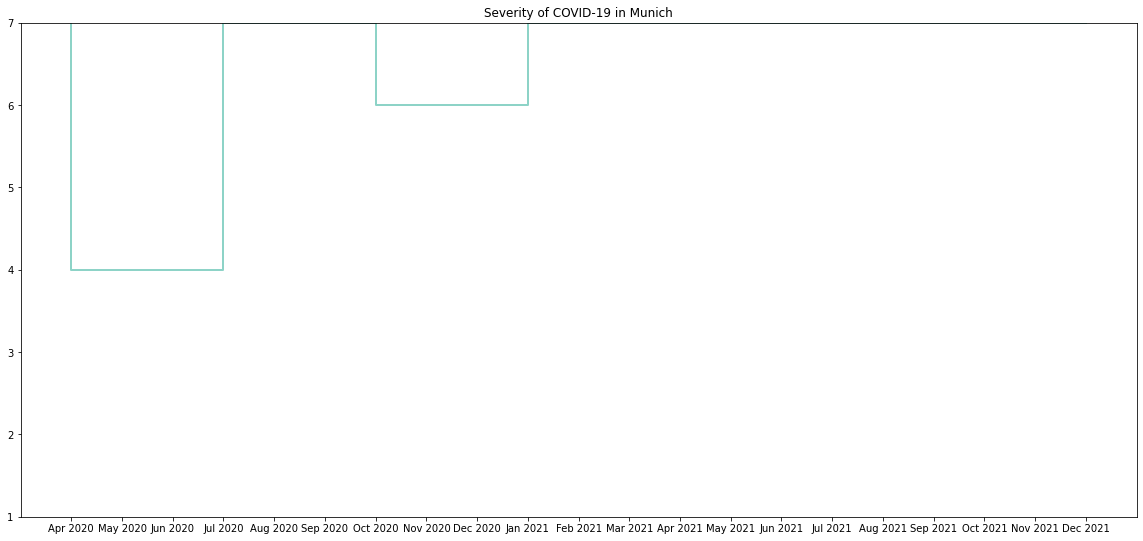

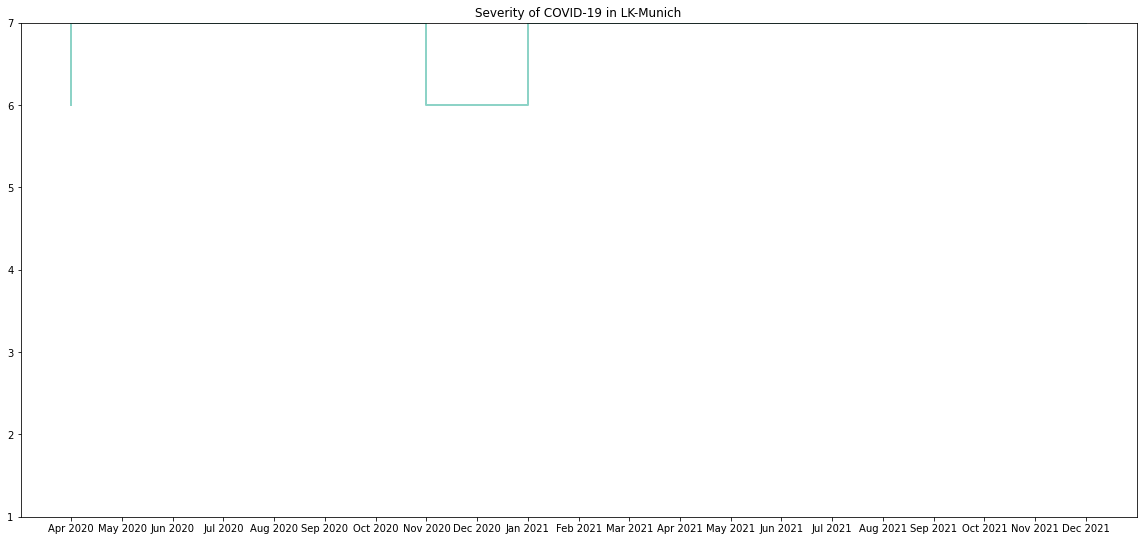

In [61]:
# visualize the result in plt
months = ['Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020',
              'Dec 2020', 'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021', 'Jul 2021',
              'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 2021']

vis.vis_plt(trajectory_Munich, 'Severity of COVID-19 in Munich', months)
vis.vis_plt(trajectory_LK_Munich, 'Severity of COVID-19 in LK-Munich', months)

In [62]:
# visualize the result in DataFrame
data = [months, list(trajectory_Munich), list(trajectory_LK_Munich)]
df = vis.vis_dataframe(data)
df

,Months,Munich,LK_Munich
0,Apr 2020,7,6
1,May 2020,4,7
2,Jun 2020,4,7
3,Jul 2020,4,7
4,Aug 2020,7,7
5,Sep 2020,7,7
6,Oct 2020,7,7
7,Nov 2020,6,7
8,Dec 2020,6,6
9,Jan 2021,6,6
